In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ncx2

In [2]:
file = pd.read_csv('discount.csv', index_col = 0, parse_dates = True)
df = file['discount']
df

term
0.25     0.994018
0.50     0.991847
0.75     0.985719
1.00     0.979189
1.25     0.972400
1.50     0.965407
1.75     0.958313
2.00     0.946648
3.00     0.918169
4.00     0.890856
5.00     0.864410
6.00     0.838709
7.00     0.813701
8.00     0.789175
9.00     0.765001
10.00    0.741630
11.00    0.718651
12.00    0.696587
15.00    0.634569
20.00    0.544388
25.00    0.470307
30.00    0.408581
40.00    0.311021
50.00    0.241662
Name: discount, dtype: float64

In [3]:
len(df)

24

In [25]:
class Model:
    def __init__(self,x):
        self.r0 = x[0]
        self.kappa = x[1]
        self.theta = x[2]             
        self.sig = x[3]
        self.h = math.sqrt(self.kappa**2 + 2*self.sig**2)
        
    def A(self,tau):
        tmp = 2*self.h*np.exp((self.kappa + self.h) * tau/2)/(2*self.h + (self.kappa+self.h)*(np.exp(tau*self.h)-1))
        return pow(tmp,2*self.kappa*self.theta/(self.sig**2))

    def B(self,tau):
        return 2*(np.exp(self.h*tau)-1)/(2*self.h + (self.kappa+self.h)*(np.exp(self.h*tau)-1))
    
    def bond_price(self,tau):
        price = self.A(tau)*np.exp(-self.B(tau)*self.r0)
        return price
    
    def update_params(self,x):
        self.r0 = x[0]
        self.kappa = x[0]
        self.theta = x[1]             
        self.sig = x[2]
        self.h = math.sqrt(self.kappa**2 + 2*self.sig**2)
       
    # call option with T written on zero-coupon bond with S computed by analytical formula
    def ZBC(self,P_T,P_S,T,S,K=.96):
        tau = S-T
        B_T_S = self.B(tau)
        rho = 2*self.h/(sig**2*(np.exp(self.h*tau)-1))
        phi = (self.kappa+self.h)/(self.sig**2)
        r_mean = np.log(self.A(tau)/K)/B_T_S
        chi1 = ncx2.cdf(2*r_mean*(rho+phi+B_T_S), 4*self.kappa*self.theta/(self.sig**2), 
                       2*rho**2*self.r0*np.exp(self.h*tau)/(rho+phi+B_T_S))
        chi2 = ncx2.cdf(2*r_mean*(rho+phi), 4*self.kappa*self.theta/(self.sig**2), 
                       2*rho**2*self.r0*np.exp(self.h*tau)/(rho+phi))
        zbc = P_S*chi1 - K*P_T*chi2
        return zbc
                

In [26]:
r0 = 1.705/100
kappa = 0.2
theta = 3/100
sig = .09

m = Model([r0,kappa,theta,sig])

In [27]:
from scipy.optimize import least_squares

class Fitter:
    def __init__(self,model,bond_data,term):
        self.model = model
        self.data = bond_data
        self.term = term
        
    def day_residual(self,x):
        self.model.update_params(x)
        mode_price = [self.model.bond_price(self.term[i]) for i in range(len(self.term))]
        return mode_price - self.data
    
    def fit(self,x_guess,solver='lm'):
        res = least_squares(self.day_residual,x_guess,bounds = ([0,0,0.01,0], [0.06,1,0.06,0.2]))#obj function,x0 guess
        return res

In [28]:
term = df.index.values
bond = Fitter(m,df.values,term)

In [29]:
paras = bond.fit([0.018,0.08, 0.037, 0.071]).x
m.update_params(paras)
print("r0,kappa,theta,sig are",paras)

r0,kappa,theta,sig are [ 0.02753027  0.05696798  0.06        0.071     ]


In [30]:
# calculate analytical bond option price
# But I am not sure if the result is correct as the analytical formula contains chi-squared distribution, I do not know if it is CDF or PDF
# P_t_T = df[7]*100
# P_t_S = df[8]*100
paras = [0.02753,0.057,0.06,0.071]
m.update_params(paras)
P_t_T = df[7]
P_t_S = df[8]
print("analytical call price on bond is ",m.ZBC(P_t_T,P_t_S,2,3)*100)

analytical call price on bond is  0.955833484815


In [18]:
model_bond = 100*m.bond_price(term)
model_bond

array([ 99.31162641,  98.62317621,  97.93489924,  97.24703731,
        96.55982415,  95.87348546,  95.18823888,  94.50429404,
        91.78544715,  89.1021555 ,  86.46414397,  83.87932487,
        81.35394553,  78.89275198,  76.49916001,  74.17542652,
        71.92281552,  69.74175477,  63.62254289,  54.74577395,
        47.29311185,  40.99729167,  31.03342173,  23.61909833])

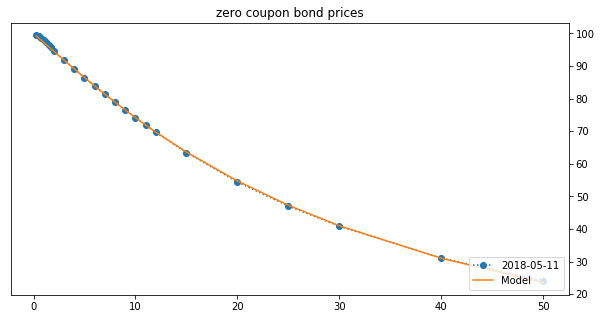

In [19]:
dt = '2018-05-11'
f = plt.figure(figsize=(10,5))#width, height in inches
ax = f.add_subplot(111)
ax.yaxis.tick_right()  #Move ticks and ticklabels (if present) to the right of the axes.
plots = [plt.plot(term,df.values*100,label=dt,linestyle="dotted",marker='o'),plt.plot(term,model_bond,label='Model')]
plt.legend(loc='lower right')    
plt.title("zero coupon bond prices")
plt.show()